In [10]:
pip install datasets transformers seqeval torch matplotlib scikit-learn -q


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report as seqeval_classification_report
from seqeval.scheme import IOB2
import torch.nn.functional as F
import copy

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [12]:
#Dataset Loading and Initial Analysis

plod_dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print("Successfully loaded PLOD-CW-25 dataset.")
print(plod_dataset)

example = plod_dataset["train"][0]
print("\nExample from train split:")
print("Tokens:", example["tokens"])
print("POS tags (raw):", example["pos_tags"])
print("NER tags (raw):", example["ner_tags"])

if hasattr(plod_dataset["train"].features["ner_tags"], 'names'):
    ner_tag_names = plod_dataset["train"].features["ner_tags"].names
    print("NER tag names from dataset:", ner_tag_names)
else:
    print("CRITICAL WARNING: Could not automatically determine ner_tag_names. Using default.")
    ner_tag_names = ['O', 'B-AC', 'B-LF', 'I-LF']

LABEL_TO_ID = {label: i for i, label in enumerate(ner_tag_names)}
ID_TO_LABEL = {i: label for i, label in enumerate(ner_tag_names)}
NUM_LABELS = len(ner_tag_names)

print(f"LABEL_TO_ID: {LABEL_TO_ID}")
print(f"ID_TO_LABEL: {ID_TO_LABEL}")
print(f"NUM_LABELS: {NUM_LABELS}")

all_tokens = [token for split in plod_dataset for ex in plod_dataset[split] for token in ex["tokens"]]
token_counts = Counter(all_tokens)
TOKEN_VOCAB = {token: i+2 for i, (token, _) in enumerate(token_counts.most_common())}
TOKEN_VOCAB["<PAD>"] = 0
TOKEN_VOCAB["<UNK>"] = 1
ID_TO_TOKEN = {i: token for token, i in TOKEN_VOCAB.items()}
TOKEN_VOCAB_SIZE = len(TOKEN_VOCAB)
print(f"Token Vocab Size: {TOKEN_VOCAB_SIZE}")

# Build POS tag vocabulary
all_pos_tags = [tag for split in plod_dataset for ex in plod_dataset[split] for tag in ex["pos_tags"]]
pos_tag_counts = Counter(all_pos_tags)
# Start POS ID from 1, reserve 0 for padding
POS_VOCAB = {tag: i+1 for i, (tag, _) in enumerate(pos_tag_counts.most_common())}
POS_VOCAB["<PAD>"] = 0 # Add padding token for POS tags
ID_TO_POS = {i: tag for tag, i in POS_VOCAB.items()}
POS_VOCAB_SIZE = len(POS_VOCAB)
print(f"POS Vocab Size: {POS_VOCAB_SIZE}")


Successfully loaded PLOD-CW-25 dataset.
DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

Example from train split:
Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
POS tags (raw): ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
NER tags (raw): ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
CRITICAL WARNING: Could not automatically determine ner_tag_names. Using default.
LABEL_TO_ID: {'O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}
ID_TO_LABEL: {0: 'O', 1: 'B-AC', 2: 'B-LF', 3: 'I-LF'}
NUM_LABELS: 4
Token Vocab Size: 16493
POS Vocab Size: 18


In [13]:


# Data Preprocessing & DataLoader
class PlodTokenClassificationDataset(Dataset):
    def __init__(self, examples, token_vocab, pos_vocab, label_to_id):
        self.tokens = []
        self.pos_tags_data = []
        self.labels = []
        # Determine if NER tags are strings or integers based on the first example
        sample_ner_tags = examples[0]["ner_tags"]
        are_ner_tags_strings = isinstance(sample_ner_tags[0], str)
        if are_ner_tags_strings: print("Detected NER tags in source data are STRINGS.")
        else: print("Detected NER tags in source data are INTEGERS.")

        for example in examples:
            self.tokens.append([token_vocab.get(tok, token_vocab["<UNK>"]) for tok in example["tokens"]])
            current_ner_tags = example["ner_tags"]
            if are_ner_tags_strings:
                self.labels.append([label_to_id.get(tag, label_to_id.get('O', 0)) for tag in current_ner_tags])
            else:
                # Assume integer tags are already correct IDs or require mapping
                # If they are raw dataset integers, this might need adjustment
                self.labels.append([int(tag) for tag in current_ner_tags])

            # Map string POS tags to integer IDs using the POS vocabulary
            self.pos_tags_data.append([pos_vocab.get(p, pos_vocab["<PAD>"]) for p in example["pos_tags"]])


    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return {"tokens": self.tokens[idx], "pos_tags": self.pos_tags_data[idx], "labels": self.labels[idx]}

def collate_fn(batch):
    tokens_list = [torch.tensor(item["tokens"]) for item in batch]
    pos_tags_list = [torch.tensor(item["pos_tags"]) for item in batch]
    labels_list = [torch.tensor(item["labels"]) for item in batch]
    padded_tokens = nn.utils.rnn.pad_sequence(tokens_list, batch_first=True, padding_value=TOKEN_VOCAB["<PAD>"])
    # Use POS_VOCAB["<PAD>"] as padding value for POS tags
    padded_pos_tags = nn.utils.rnn.pad_sequence(pos_tags_list, batch_first=True, padding_value=POS_VOCAB["<PAD>"])
    padded_labels = nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=-100)
    return {"tokens": padded_tokens.to(DEVICE), "pos_tags": padded_pos_tags.to(DEVICE), "labels": padded_labels.to(DEVICE)}

# Pass the POS_VOCAB to the dataset constructor
train_dataset = PlodTokenClassificationDataset(plod_dataset["train"], TOKEN_VOCAB, POS_VOCAB, LABEL_TO_ID)
val_dataset = PlodTokenClassificationDataset(plod_dataset["validation"], TOKEN_VOCAB, POS_VOCAB, LABEL_TO_ID)
test_dataset = PlodTokenClassificationDataset(plod_dataset["test"], TOKEN_VOCAB, POS_VOCAB, LABEL_TO_ID)


BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"Train Dataloader: {len(train_dataloader)} batches, Val: {len(val_dataloader)}, Test: {len(test_dataloader)}")
batch_sample = next(iter(train_dataloader))
print("\nSample batch shapes: Tokens:", batch_sample["tokens"].shape, "POS:", batch_sample["pos_tags"].shape, "Labels:", batch_sample["labels"].shape)


Detected NER tags in source data are STRINGS.
Detected NER tags in source data are STRINGS.
Detected NER tags in source data are STRINGS.
Train Dataloader: 63 batches, Val: 5, Test: 8

Sample batch shapes: Tokens: torch.Size([32, 123]) POS: torch.Size([32, 123]) Labels: torch.Size([32, 123])


In [14]:

#  Model
class BiLSTMPOSTag(nn.Module):
    def __init__(self, token_vocab_size, token_embedding_dim, pos_vocab_size, pos_embedding_dim, hidden_dim, num_labels, dropout_rate=0.3):
        super().__init__()
        self.token_embedding = nn.Embedding(token_vocab_size, token_embedding_dim, padding_idx=TOKEN_VOCAB["<PAD>"])
        # Ensure POS embedding uses the correct vocab size and padding idx
        self.pos_embedding = nn.Embedding(pos_vocab_size, pos_embedding_dim, padding_idx=POS_VOCAB["<PAD>"])
        self.embedding_dim = token_embedding_dim + pos_embedding_dim
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, tokens, pos_tags):
        token_embedded = self.token_embedding(tokens)
        pos_embedded = self.pos_embedding(pos_tags)
        combined_embeddings = torch.cat((token_embedded, pos_embedded), dim=2)
        lstm_out, _ = self.lstm(combined_embeddings)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)
        return logits

TOKEN_EMBEDDING_DIM = 100
POS_EMBEDDING_DIM = 25
HIDDEN_DIM = 128
DROPOUT_RATE = 0.33

In [15]:

# Custom Loss Functions
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        num_classes = logits.size(-1)
        logits_flat = logits.view(-1, num_classes)
        targets_flat = targets.view(-1)
        mask = (targets_flat != self.ignore_index)
        logits_filtered = logits_flat[mask]
        targets_filtered = targets_flat[mask]
        if logits_filtered.numel() == 0: return torch.tensor(0.0, device=logits.device, requires_grad=True)
        log_probs = F.log_softmax(logits_filtered, dim=1)
        probs = torch.exp(log_probs)
        pt = probs.gather(1, targets_filtered.unsqueeze(1)).squeeze(1)
        ce_loss = F.cross_entropy(logits_filtered, targets_filtered, reduction='none', weight=self.alpha.to(logits.device) if self.alpha is not None else None)
        focal_term = (1 - pt)**self.gamma
        loss = focal_term * ce_loss
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.confidence = 1.0 - smoothing

    def forward(self, logits, targets):
        logits_flat = logits.view(-1, self.num_classes)
        targets_flat = targets.view(-1)
        mask = (targets_flat != self.ignore_index)
        logits_masked = logits_flat[mask]
        targets_masked = targets_flat[mask]
        if logits_masked.numel() == 0: return torch.tensor(0.0, device=logits.device, requires_grad=True)
        log_probs = F.log_softmax(logits_masked, dim=1)
        smooth_targets_dist = torch.full_like(log_probs, self.smoothing / (self.num_classes - 1))
        smooth_targets_dist.scatter_(1, targets_masked.unsqueeze(1), self.confidence)
        loss = -torch.sum(smooth_targets_dist * log_probs, dim=1)
        return loss.mean()

In [16]:


# Training and Evaluation Utilities
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        tokens, pos_tags, labels = batch["tokens"], batch["pos_tags"], batch["labels"]
        optimizer.zero_grad()
        logits = model(tokens, pos_tags)
        loss = criterion(logits.view(-1, NUM_LABELS), labels.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, id_to_label_map):
    model.eval()
    epoch_loss = 0
    all_true_labels_sequences, all_pred_labels_sequences = [], []
    with torch.no_grad():
        for batch in dataloader:
            tokens, pos_tags, labels = batch["tokens"], batch["pos_tags"], batch["labels"]
            logits = model(tokens, pos_tags)
            loss = criterion(logits.view(-1, NUM_LABELS), labels.view(-1))
            epoch_loss += loss.item()
            predictions = torch.argmax(logits, dim=2)
            for i in range(labels.size(0)):
                true_seq, pred_seq = [], []
                for j in range(labels.size(1)):
                    if labels[i, j].item() != -100:
                        true_seq.append(id_to_label_map[labels[i, j].item()])
                        pred_seq.append(id_to_label_map[predictions[i, j].item()])
                if true_seq:
                    all_true_labels_sequences.append(true_seq)
                    all_pred_labels_sequences.append(pred_seq)
    avg_loss = epoch_loss / len(dataloader)
    report_dict = seqeval_classification_report(all_true_labels_sequences, all_pred_labels_sequences, output_dict=True, mode='strict', scheme=IOB2, zero_division=0)
    flat_true = [label for seq in all_true_labels_sequences for label in seq]
    flat_pred = [label for seq in all_pred_labels_sequences for label in seq]
    cm_labels = sorted(list(set(flat_true + flat_pred)))
    if not cm_labels: cm_labels = list(id_to_label_map.values())
    return avg_loss, report_dict, all_true_labels_sequences, all_pred_labels_sequences, cm_labels


In [17]:


# train
NUM_EPOCHS = 10
LEARNING_RATE_ADAM = 1e-3
LEARNING_RATE_ADAMW = 1e-3
LEARNING_RATE_SGD = 1e-2
all_experiment_results = {}

#  A: BiLSTM + CrossEntropyLoss + Adam
print("\n---  A: BiLSTM + CrossEntropyLoss + Adam ---")
model_A = BiLSTMPOSTag(TOKEN_VOCAB_SIZE, TOKEN_EMBEDDING_DIM, POS_VOCAB_SIZE, POS_EMBEDDING_DIM, HIDDEN_DIM, NUM_LABELS, DROPOUT_RATE).to(DEVICE)
criterion_A = nn.CrossEntropyLoss(ignore_index=-100)
optimizer_A = optim.Adam(model_A.parameters(), lr=LEARNING_RATE_ADAM)
history_A = {'train_loss': [], 'val_loss': [], 'val_f1': []}
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_A, train_dataloader, optimizer_A, criterion_A)
    val_loss, val_report, _, _, _ = evaluate(model_A, val_dataloader, criterion_A, ID_TO_LABEL)
    history_A['train_loss'].append(train_loss); history_A['val_loss'].append(val_loss)
    history_A['val_f1'].append(val_report['micro avg']['f1-score'])
    print(f"A - Ep {epoch+1}: Tr Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_report['micro avg']['f1-score']:.4f}")
all_experiment_results['BiLSTM + CrossEntropyLoss + Adam'] = {'model': model_A, 'history': history_A, 'criterion': criterion_A, 'optimizer_type': 'Adam'}

#  B: BiLSTM + Focal Loss + AdamW
print("\n---  B: BiLSTM + Focal Loss + AdamW ---")
model_B = BiLSTMPOSTag(TOKEN_VOCAB_SIZE, TOKEN_EMBEDDING_DIM, POS_VOCAB_SIZE, POS_EMBEDDING_DIM, HIDDEN_DIM, NUM_LABELS, DROPOUT_RATE).to(DEVICE)
criterion_B = FocalLoss(alpha=None, gamma=2.0, ignore_index=-100)
optimizer_B = optim.AdamW(model_B.parameters(), lr=LEARNING_RATE_ADAMW)
history_B = {'train_loss': [], 'val_loss': [], 'val_f1': []}
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_B, train_dataloader, optimizer_B, criterion_B)
    val_loss, val_report, _, _, _ = evaluate(model_B, val_dataloader, criterion_B, ID_TO_LABEL)
    history_B['train_loss'].append(train_loss); history_B['val_loss'].append(val_loss)
    history_B['val_f1'].append(val_report['micro avg']['f1-score'])
    print(f"B - Ep {epoch+1}: Tr Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_report['micro avg']['f1-score']:.4f}")
all_experiment_results['BiLSTM + Focal Loss + AdamW'] = {'model': model_B, 'history': history_B, 'criterion': criterion_B, 'optimizer_type': 'AdamW'}

#  C: BiLSTM + Label Smoothing Loss + SGD
print("\n---  C: BiLSTM + Label Smoothing Loss + SGD ---")
model_C = BiLSTMPOSTag(TOKEN_VOCAB_SIZE, TOKEN_EMBEDDING_DIM, POS_VOCAB_SIZE, POS_EMBEDDING_DIM, HIDDEN_DIM, NUM_LABELS, DROPOUT_RATE).to(DEVICE)
criterion_C = LabelSmoothingLoss(num_classes=NUM_LABELS, smoothing=0.1, ignore_index=-100)
optimizer_C = optim.SGD(model_C.parameters(), lr=LEARNING_RATE_SGD, momentum=0.9)
history_C = {'train_loss': [], 'val_loss': [], 'val_f1': []}
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_C, train_dataloader, optimizer_C, criterion_C)
    val_loss, val_report, _, _, _ = evaluate(model_C, val_dataloader, criterion_C, ID_TO_LABEL)
    history_C['train_loss'].append(train_loss); history_C['val_loss'].append(val_loss)
    history_C['val_f1'].append(val_report['micro avg']['f1-score'])
    print(f"C - Ep {epoch+1}: Tr Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_report['micro avg']['f1-score']:.4f}")
all_experiment_results['BiLSTM + Label Smoothing Loss + SGD'] = {'model': model_C, 'history': history_C, 'criterion': criterion_C, 'optimizer_type': 'SGD'}



---  A: BiLSTM + CrossEntropyLoss + Adam ---
A - Ep 1: Tr Loss: 0.6945, Val Loss: 0.4592, Val F1: 0.4861
A - Ep 2: Tr Loss: 0.3822, Val Loss: 0.3766, Val F1: 0.6310
A - Ep 3: Tr Loss: 0.3067, Val Loss: 0.3523, Val F1: 0.6774
A - Ep 4: Tr Loss: 0.2660, Val Loss: 0.3560, Val F1: 0.6527
A - Ep 5: Tr Loss: 0.2345, Val Loss: 0.3505, Val F1: 0.6973
A - Ep 6: Tr Loss: 0.2025, Val Loss: 0.3642, Val F1: 0.6788
A - Ep 7: Tr Loss: 0.1753, Val Loss: 0.4033, Val F1: 0.6754
A - Ep 8: Tr Loss: 0.1472, Val Loss: 0.4043, Val F1: 0.6851
A - Ep 9: Tr Loss: 0.1221, Val Loss: 0.4281, Val F1: 0.6813
A - Ep 10: Tr Loss: 0.1013, Val Loss: 0.4599, Val F1: 0.6628

---  B: BiLSTM + Focal Loss + AdamW ---
B - Ep 1: Tr Loss: 0.3014, Val Loss: 0.1967, Val F1: 0.5429
B - Ep 2: Tr Loss: 0.1547, Val Loss: 0.1551, Val F1: 0.6459
B - Ep 3: Tr Loss: 0.1184, Val Loss: 0.1446, Val F1: 0.6190
B - Ep 4: Tr Loss: 0.0994, Val Loss: 0.1396, Val F1: 0.6603
B - Ep 5: Tr Loss: 0.0847, Val Loss: 0.1374, Val F1: 0.7007
B - Ep 6: Tr


--- 7. Evaluation & Result Plotting ---


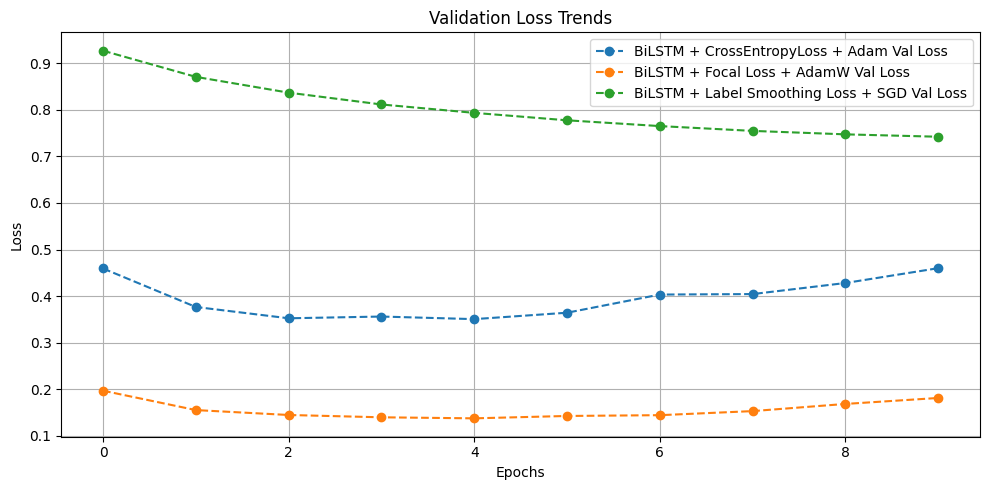

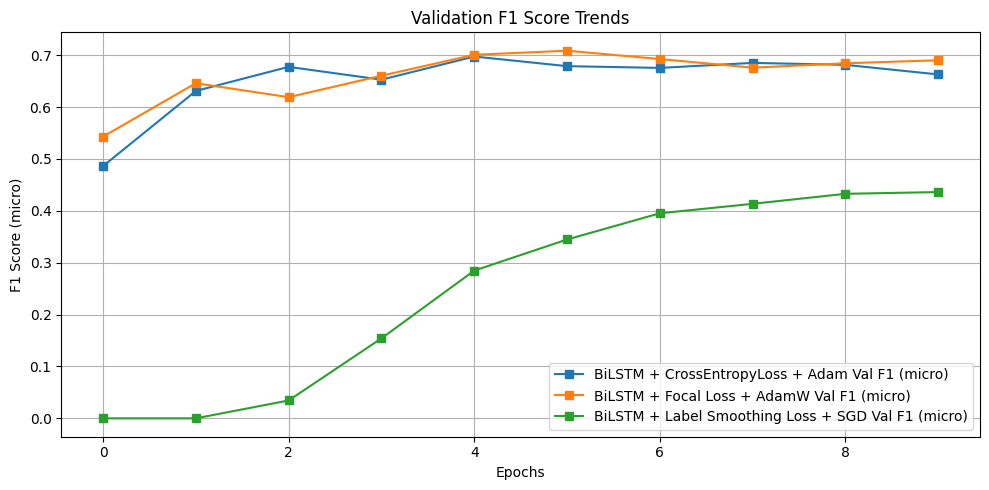


--- Detailed Test Set Evaluation ---

--- Evaluating BiLSTM + CrossEntropyLoss + Adam on Test Set ---
BiLSTM + CrossEntropyLoss + Adam - Test Loss: 0.3375, Micro F1: 0.7059, Macro F1: 0.6864
              precision    recall  f1-score   support

          AC       0.78      0.75      0.76       797
          LF       0.63      0.59      0.61       482

   micro avg       0.72      0.69      0.71      1279
   macro avg       0.70      0.67      0.69      1279
weighted avg       0.72      0.69      0.71      1279



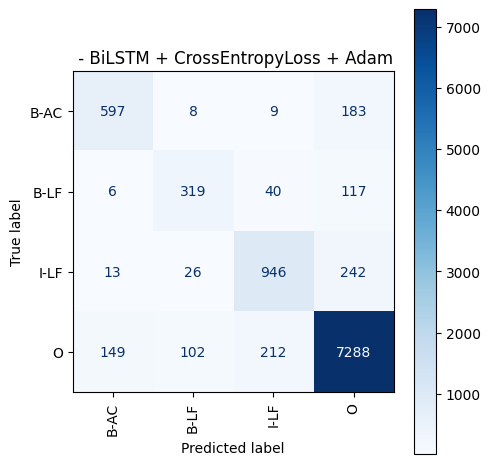


--- Evaluating BiLSTM + Focal Loss + AdamW on Test Set ---
BiLSTM + Focal Loss + AdamW - Test Loss: 0.1348, Micro F1: 0.7255, Macro F1: 0.7066
              precision    recall  f1-score   support

          AC       0.76      0.79      0.78       797
          LF       0.66      0.61      0.64       482

   micro avg       0.73      0.72      0.73      1279
   macro avg       0.71      0.70      0.71      1279
weighted avg       0.73      0.72      0.72      1279



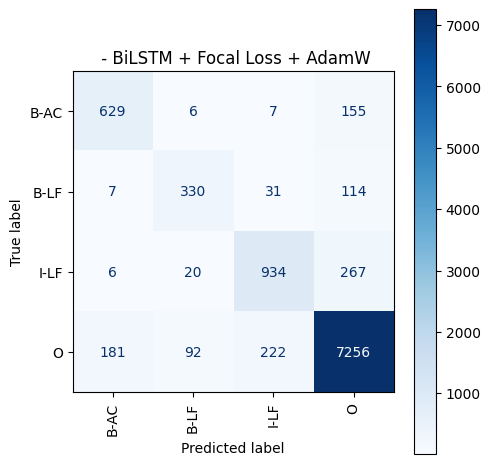


--- Evaluating BiLSTM + Label Smoothing Loss + SGD on Test Set ---
BiLSTM + Label Smoothing Loss + SGD - Test Loss: 0.7188, Micro F1: 0.4293, Macro F1: 0.3394
              precision    recall  f1-score   support

          AC       0.65      0.48      0.55       797
          LF       0.51      0.07      0.13       482

   micro avg       0.63      0.33      0.43      1279
   macro avg       0.58      0.28      0.34      1279
weighted avg       0.60      0.33      0.39      1279



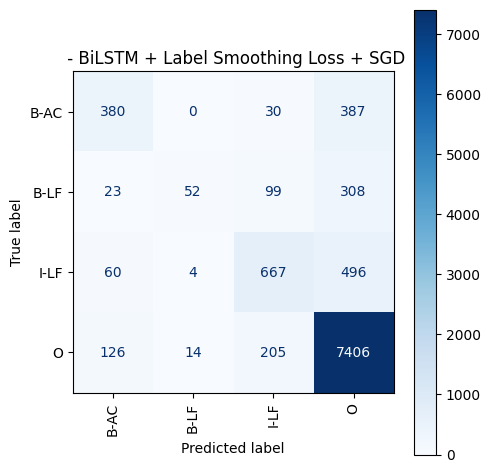

In [18]:

# Evaluation & Result Plotting
print("\n--- 7. Evaluation & Result Plotting ---")
plt.figure(figsize=(10, 5))
for name, results in all_experiment_results.items():
    plt.plot(results['history']['val_loss'], label=f"{name} Val Loss", marker='o', linestyle='--')
plt.title('Validation Loss Trends'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
for name, results in all_experiment_results.items():
    plt.plot(results['history']['val_f1'], label=f"{name} Val F1 (micro)", marker='s')
plt.title('Validation F1 Score Trends'); plt.xlabel('Epochs'); plt.ylabel('F1 Score (micro)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("\n--- Detailed Test Set Evaluation ---")
test_reports_summary = {}
for name, results in all_experiment_results.items():
    print(f"\n--- Evaluating {name} on Test Set ---")
    model_to_test = results['model']; criterion_for_eval = results['criterion']
    test_loss, test_report_dict, test_true_seqs, test_pred_seqs, cm_labels_test = evaluate(model_to_test, test_dataloader, criterion_for_eval, ID_TO_LABEL)
    test_reports_summary[name] = {
        'loss': test_loss, 'report_dict': test_report_dict,
        'micro_f1': test_report_dict.get('micro avg', {}).get('f1-score', 0),
        'macro_f1': test_report_dict.get('macro avg', {}).get('f1-score', 0)}
    print(f"{name} - Test Loss: {test_loss:.4f}, Micro F1: {test_reports_summary[name]['micro_f1']:.4f}, Macro F1: {test_reports_summary[name]['macro_f1']:.4f}")
    print(seqeval_classification_report(test_true_seqs, test_pred_seqs, mode='strict', scheme=IOB2, zero_division=0))
    flat_true_test = [label for seq in test_true_seqs for label in seq]
    flat_pred_test = [label for seq in test_pred_seqs for label in seq]
    if not cm_labels_test and (flat_true_test or flat_pred_test): cm_labels_test = sorted(list(set(flat_true_test + flat_pred_test)))
    elif not cm_labels_test: cm_labels_test = sorted(list(ID_TO_LABEL.values()))
    if flat_true_test and flat_pred_test:
        try:
            cm = confusion_matrix(flat_true_test, flat_pred_test, labels=cm_labels_test)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels_test)
            fig, ax = plt.subplots(figsize=(max(5, len(cm_labels_test)//1.5), max(5, len(cm_labels_test)//1.5)))
            disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues'); plt.title(f' - {name}'); plt.tight_layout(); plt.show()
        except Exception as e: print(f"CM plot error for {name}: {e}")
    else: print(f"No data for CM for {name}.")

